In [3]:
import torch
import numpy as np
from ImportFile import *
import itertools

import os
cwd = os.getcwd()
cwd

'/Users/baigm/courses/biye/code/BaiPinns'

In [4]:
# plot mean, var wrt ensemble for original params
def plotting(models, images_path, extrema):
    '''
    Function to make plots
    Args:
        model: neural network approximating the solution
        images_path: path where to save plots
        extrema:  extrema of the domain
        solid:
    '''
    
    n = 100
    x = torch.reshape(torch.linspace(extrema[1, 0], extrema[1, 1], n), [n, 1])
    time_steps = Ec.extrema_values[0, :].detach().numpy()    #[-5., 5.]
    scale_vec = np.linspace(0.65, 1.55, len(time_steps))
    
    
    fig = plt.figure()
    plt.grid(True, which="both", ls=":")
    for val, scale in zip(time_steps, scale_vec):
        plot_var = torch.cat([torch.tensor(()).new_full(size=(n, 1), fill_value=val), x], 1)

        # UQ single
        alpha = torch.full(size=(x.shape[0], 1), fill_value=9., dtype=torch.float)
        beta = torch.full(size=(x.shape[0], 1), fill_value=-0., dtype=torch.float)
        gamma = torch.full(size=(x.shape[0], 1), fill_value=1., dtype=torch.float)
        kappa = torch.full(size=(x.shape[0], 1), fill_value=1., dtype=torch.float)
        
        plot_var = torch.cat([plot_var, alpha, beta, gamma, kappa], 1)
        
        num_para = 4
        t_vals = np.zeros((n, len(models)))
        i = 0
        for model in models:
            model.cpu()
            model = model.eval()
            t_vals[:, i] =  model(plot_var).detach().numpy().reshape(-1)
            i += 1
            
        t_vals_avg = np.mean(t_vals, axis = 1)
        t_vals_var = np.var(t_vals, axis = 1)

        print(t_vals_avg.shape)
        print(t_vals_var.shape)
        

        # UQ double
        # a = torch.full(size=(x.shape[0], 1), fill_value=0.5, dtype=torch.float)
        # b = torch.full(size=(x.shape[0], 1), fill_value=1.0, dtype=torch.float)
        # plot_var = torch.cat([plot_var, a, b], 1)

#         plt.plot(x, t_vals_avg - Ec.exact(plot_var).detach().numpy().reshape(-1), 'b-', linewidth=2, label=r'Mean, $t=$' + str(val) + r'$s$', color=lighten_color('grey', scale), zorder=0)
#         plt.scatter(x, t_vals_avg, label=r'Predicted, $t=$' + str(val) + r'$s$', marker="o", s=14,
#                     color=lighten_color('C0', scale), zorder=10)
        plt.errorbar(x, t_vals_avg - Ec.exact(plot_var).detach().numpy().reshape(-1), yerr=t_vals_var, label=r'Mean, $t=$' + str(val) + r'$s$', color=lighten_color('grey', scale), zorder=0)
#         plt.plot(x, t_vals_avg - Ec.exact(plot_var).detach().numpy().reshape(-1), 'b-', linewidth=2, label=r'Mean, $t=$' + str(val) + r'$s$', color=lighten_color('grey', scale), zorder=0))
#         plt.bar(plot_var[:, 1].detach().numpy(), t_vals_var, color="w", yerr=t_vals_var)

#         print(np.max(t_vals_avg - Ec.exact(plot_var).detach().numpy().reshape(-1)))
#     print(t_vals_var)

    plt.xlabel(r'$x$')
    plt.ylabel(r'u')
    plt.legend()
    plt.savefig(images_path + "/Samples.png", dpi=500)
    
    
    


In [19]:
# plot mean, var wrt params for optimal ensemble
def plotting1(model, images_path, extrema):
    '''
    Function to make plots
    Args:
        model: neural network approximating the solution
        images_path: path where to save plots
        extrema:  extrema of the domain
        solid:
    '''
    
    n = 100
    x = torch.reshape(torch.linspace(extrema[1, 0], extrema[1, 1], n), [n, 1])
    time_steps = Ec.extrema_values[0, :].detach().numpy()    #[-5., 5.]
    scale_vec = np.linspace(0.65, 1.55, len(time_steps))
    
    mean_exact = torch.zeros(n)
    var_exact = torch.zeros(n)
    mean = torch.zeros(n)
    var = torch.zeros(n)
    
    
    fig = plt.figure()
    plt.grid(True, which="both", ls=":")
    for val, scale in zip(time_steps, scale_vec):
        plot_var = torch.cat([torch.tensor(()).new_full(size=(n, 1), fill_value=val), x], 1)

        # UQ single
        samples = 10000
        
#         parameters_values = Ec.parameters_values
        parameters_values = torch.tensor([[8.5, 9.5], # alpha
                  [-0.4, 0.4], # beta
                    [0.9, 1.1], # gamma
                  [0.9, 1.1]]) # kappa
        alpha = torch.FloatTensor(samples, 1).uniform_(parameters_values[0,0], parameters_values[0,1])
        beta = torch.FloatTensor(samples, 1).uniform_(parameters_values[1,0], parameters_values[1,1])
        gamma = torch.FloatTensor(samples, 1).uniform_(parameters_values[2,0], parameters_values[2,1])
        kappa = torch.FloatTensor(samples, 1).uniform_(parameters_values[3,0], parameters_values[3,1])
        
        for i in range(n):
            pos = x[i]
            x_pos = torch.full(size=(samples, 1), fill_value=pos[0], dtype=torch.float)
            t = torch.full(size=(samples, 1), fill_value=val, dtype=torch.float)
            vari = torch.cat([t, x_pos, alpha, beta, gamma, kappa], 1)
            heights_exact = Ec.exact(vari).detach().numpy().reshape(-1)
            model(vari)
#             heights = model(vari).detach().numpy().reshape(-1)
            mean_exact[i] = torch.mean(torch.from_numpy(heights_exact))
            var_exact[i] = torch.var(torch.from_numpy(heights_exact))
#             mean[i] = torch.mean(torch.from_numpy(heights))
#             var[i] = torch.var(torch.from_numpy(heights))

        plt.plot(x.reshape(-1), mean_exact, 'k-', label=r'Mean, $t=$' + str(val) + r'$s$', color=lighten_color('grey', scale), zorder=0)
        plt.fill_between(x.reshape(-1), mean_exact-var_exact, mean_exact+var_exact, alpha=0.3, color=lighten_color('grey', scale))
#         plt.plot(x.reshape(-1), mean, 'k-', label=r'Mean, $t=$' + str(val) + r'$s$', color=lighten_color('C0', scale), zorder=0)
#         plt.fill_between(x.reshape(-1), mean-var, mean+var, alpha=0.3, color=lighten_color('C0', scale))


    plt.xlabel(r'$x$')
    plt.ylabel(r'u')
    plt.legend()
    plt.savefig(images_path + "/Samples.png", dpi=500)

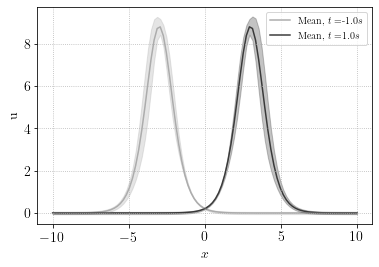

In [20]:
d = 'kdv_single_uq_/Setup_14/Retrain_4'
path = cwd + '/' + d + '/TrainedModel/model.pkl'
# print(path)
model = torch.load(path, map_location=torch.device('cpu'))

plotting1(model, base_path, Ec.extrema_values) # _f, _i, _ if

In [7]:
# base_path_list = ["kdv_single_cp", "kdv_double_cp", "Kawa_single_cp",
#                   "CH_single_lim1_cp", "CH_double_lim1_cp", "BO_single_enh4_1_cp", "BO_double_enh30_cp"]
# base_path_list = ["Kawa_double2_cp", "Kawa_gen_cp", "Kawa_agen_cp"]
folder = 'kdv_single_uq_'
import EquationModels.DispersiveEquation.KdV as Ec
folder_path = "legend_update" # "cp_fig1"
# iters = ['1000', '2000', '5000']
images_path = cwd + "/" + folder_path

base_path = folder
models_path = []
directories_setup = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
for dir_setup in directories_setup:
    setup_path = base_path + '/' +  str(dir_setup)
    directories_retrain = [d for d in os.listdir(setup_path) if os.path.isdir(os.path.join(setup_path, d))]
    for dir_retrain in directories_retrain:
        retrain_path = setup_path + '/' +  str(dir_retrain)
        models_path.append(retrain_path)
#         print(retrain_path)

models = []
for d in models_path:
    path = cwd + '/' + d + '/TrainedModel/model.pkl'
#     print(path)
    model = torch.load(path, map_location=torch.device('cpu'))
    models.append(model)

# plotting(models, base_path, Ec.extrema_values, folder + "_uq") # _f, _i, _ if
# type(models)



# plot for /Kawa_double2/Setup_11/Retrain_2/TrainedModel/model.pkl
# path = cwd + '/Kawa_double2/Setup_11/Retrain_2/TrainedModel/model.pkl'
# path
#
# model = torch.load(path)
# model
#
#
# images_path = cwd + "/TestBai"
# Ec.plotting(model, images_path, Ec.extrema_values, None)



(100,)
(100,)
(100,)
(100,)


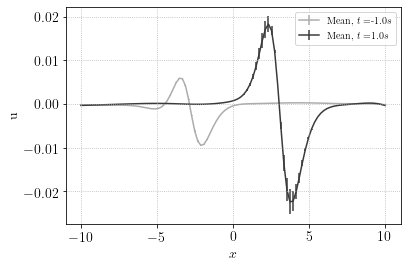

In [8]:
plotting(models, base_path, Ec.extrema_values) # _f, _i, _ if

In [14]:
a = [1, 2, 3]

In [22]:
a[0]

for i in range(len(a)):
    print(a[i])

1
2
3


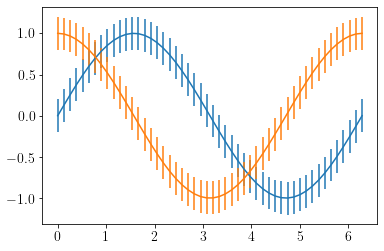

In [106]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
y_sin = np.sin(x)
y_cos = np.cos(x)
plt.errorbar(x, y_sin, 0.2)
plt.errorbar(x, y_cos, 0.2)
plt.show()

In [111]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
#     if color is None:
#         color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color='r')
    ax.fill_between(x, ymax, ymin, color='r', alpha=alpha_fill)

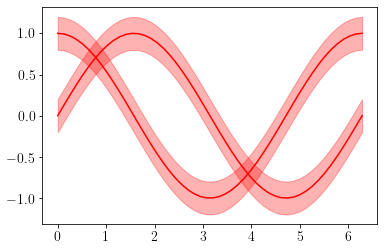

In [112]:
errorfill(x, y_sin, 0.2)
errorfill(x, y_cos, 0.2)
plt.show()